In [22]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import ta  # for technical indicators
import matplotlib.pyplot as plt
import seaborn as sns

# Placeholder for later sentiment data
# sentiment_data = None  # Reserved for sentiment analysis integration later

# Set global visualization style
sns.set(style="whitegrid")

print("Libraries loaded and ready.")

Libraries loaded and ready.


In [23]:
# Placeholder for later sentiment data
# sentiment_data = None  # Reserved for sentiment analysis integration later

# Set global visualization style
sns.set(style="whitegrid")

print("Libraries loaded and ready.")

# Step 1: Fetch historical price data
def fetch_historical_data(symbol, interval, start_date, end_date):
    """Fetch historical OHLCV data from a crypto exchange API."""
    # Placeholder for fetching data. This will later use an API like Binance or CCXT.
    # For now, we simulate with random data.
    date_range = pd.date_range(start=start_date, end=end_date, freq=interval)
    data = {
        'timestamp': date_range,
        'open': np.random.rand(len(date_range)) * 100,
        'high': np.random.rand(len(date_range)) * 100,
        'low': np.random.rand(len(date_range)) * 100,
        'close': np.random.rand(len(date_range)) * 100,
        'volume': np.random.rand(len(date_range)) * 1000
    }
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    return df

# Example usage
symbol = "BTCUSDT"
interval = "1H"
start_date = "2022-01-01"
end_date = "2025-12-31"
data = fetch_historical_data(symbol, interval, start_date, end_date)
print(data.head())
print(data.tail())

Libraries loaded and ready.
                          open       high        low      close      volume
timestamp                                                                  
2022-01-01 00:00:00  48.790196  94.176185  73.334148  79.774811  415.371885
2022-01-01 01:00:00  55.999520  98.339142   7.283801  69.903672  248.444253
2022-01-01 02:00:00   8.027447  68.508976  86.116802  83.826538  325.252529
2022-01-01 03:00:00  31.395788  27.318251  75.041862  26.986525  911.583952
2022-01-01 04:00:00  44.649542  79.112487  38.675159  37.829894  423.228888
                          open       high        low      close      volume
timestamp                                                                  
2025-12-30 20:00:00  77.741379  42.203660  85.673551  17.562281   52.152789
2025-12-30 21:00:00  80.842094  73.704971  50.789088  44.822857  975.366470
2025-12-30 22:00:00  72.539342  31.434799  47.686045  76.147832  400.378370
2025-12-30 23:00:00  51.891210   7.640494  85.006574   0.582

In [24]:
# Step 2: Data Preprocessing
def preprocess_data(df):
    """Preprocess the data: sort, fill missing values, normalize."""
    # Ensure data is sorted by timestamp
    df = df.sort_index()

    # Handle missing values
    df = df.fillna(method='ffill').fillna(method='bfill')

    # Add normalized columns for scaling later
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    return df, normalized_df, scaler

# Preprocess the data
raw_data, normalized_data, data_scaler = preprocess_data(data)
print("Preprocessing complete. Raw and normalized data ready.")


Preprocessing complete. Raw and normalized data ready.


C:\Users\Me\AppData\Local\Temp\ipykernel_9168\75010912.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [25]:
# Step 3: Feature Engineering
def add_technical_indicators(df):
    """Add technical indicators as features."""
    # Add Relative Strength Index (RSI)
    df['rsi'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()

    # Add Bollinger Bands
    bb = ta.volatility.BollingerBands(close=df['close'], window=20)
    df['bb_high'] = bb.bollinger_hband()
    df['bb_low'] = bb.bollinger_lband()
    df['bb_width'] = bb.bollinger_wband()

    # Add Average True Range (ATR)
    df['atr'] = ta.volatility.AverageTrueRange(
        high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()

    # Add Moving Averages
    df['sma_50'] = ta.trend.SMAIndicator(close=df['close'], window=50).sma_indicator()
    df['ema_21'] = ta.trend.EMAIndicator(close=df['close'], window=21).ema_indicator()

    # Add MACD
    macd = ta.trend.MACD(close=df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_diff'] = macd.macd_diff()

    # Add Volume Indicators
    df['vol_sma_20'] = ta.volume.VolumeWeightedAveragePrice(
        high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], window=20).volume_weighted_average_price()

    # Fill any NaN values caused by indicator calculations
    df = df.fillna(method='ffill').fillna(method='bfill')

    return df

# Add technical indicators to raw data
data_with_indicators = add_technical_indicators(raw_data)
print("Feature engineering complete. Technical indicators added.")

Feature engineering complete. Technical indicators added.


C:\Users\Me\AppData\Local\Temp\ipykernel_9168\366309622.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


In [26]:
# Step 3.1: Advanced Feature Engineering
def add_advanced_features(df):
    """Add advanced features for deeper insights."""
    # Add Price Volatility Metrics
    df['price_volatility'] = df['high'] - df['low']  # Intra-candle price range
    df['volatility_ratio'] = df['price_volatility'] / df['close']

    # Add Custom Price Action Metrics
    df['price_change'] = df['close'].pct_change()  # Percentage change between closes
    df['candle_body'] = abs(df['close'] - df['open'])  # Absolute candle body size
    df['candle_wick'] = df['price_volatility'] - df['candle_body']  # Wick size

    # Add Volume-Based Metrics
    df['volume_delta'] = df['volume'].diff()  # Volume change between periods
    df['norm_volume'] = df['volume'] / df['volume'].rolling(window=20).mean()  # Normalized volume

    # Fill missing values caused by rolling windows
    df = df.fillna(method='ffill').fillna(method='bfill')

    return df

# Add advanced features
data_with_advanced_features = add_advanced_features(data_with_indicators)
print("Advanced features added.")


Advanced features added.


C:\Users\Me\AppData\Local\Temp\ipykernel_9168\37677265.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


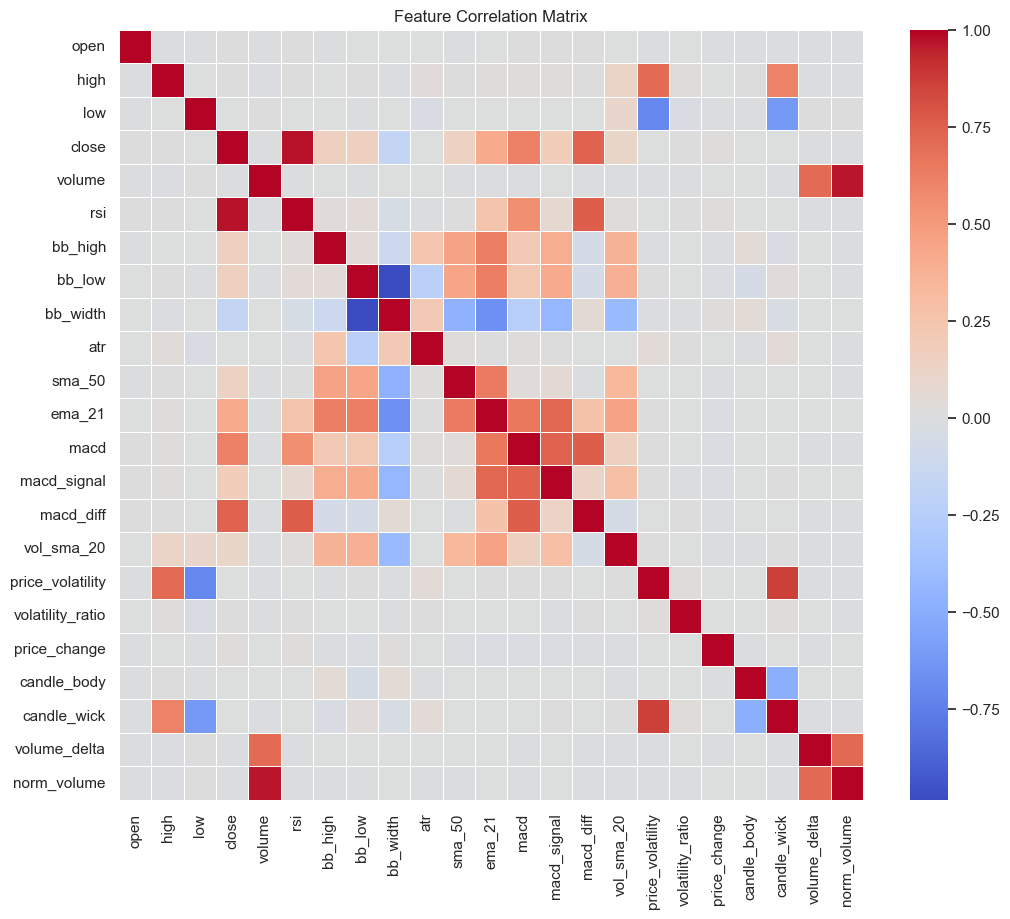

Feature selection based on correlations complete.


In [27]:
# Step 3.2: Feature Selection and Correlation Analysis
def feature_selection(df):
    """Perform initial feature selection by analyzing correlations."""
    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Visualize the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.show()

    # Return features with low multicollinearity for potential selection
    low_corr_features = correlation_matrix.columns[(correlation_matrix.abs().mean() < 0.7)]
    return df[low_corr_features]

# Perform feature selection
selected_features = feature_selection(data_with_advanced_features)
print("Feature selection based on correlations complete.")

In [28]:
# Step 4.1: Incorporate Order Book Dynamics
def add_order_book_features(df):
    """Simulate order book dynamics features for analysis."""
    # Simulate bid-ask spread and imbalance (replace with real order book data later)
    df['bid_price'] = df['close'] * (1 - np.random.uniform(0.0001, 0.0005, len(df)))
    df['ask_price'] = df['close'] * (1 + np.random.uniform(0.0001, 0.0005, len(df)))
    df['bid_ask_spread'] = df['ask_price'] - df['bid_price']

    # Simulate bid and ask volume
    df['bid_volume'] = np.random.uniform(1, 100, len(df))
    df['ask_volume'] = np.random.uniform(1, 100, len(df))

    # Calculate bid-ask imbalance
    df['bid_ask_imbalance'] = (df['bid_volume'] - df['ask_volume']) / (df['bid_volume'] + df['ask_volume'] + 1e-6)

    # Simulate spoofing by generating large temporary bid or ask orders
    df['spoofing_activity'] = np.random.choice([0, 1], size=len(df), p=[0.98, 0.02]) * np.random.uniform(0.5, 1.5, len(df))

    # Simulate order flow metrics
    df['order_flow'] = df['bid_volume'] - df['ask_volume']

    return df

# Add order book features
data_with_order_book = add_order_book_features(data_with_advanced_features)
print("Order book dynamics incorporated.")

Order book dynamics incorporated.


In [29]:
# Step 4.2: Add Microstructure Patterns
def add_microstructure_features(df):
    """Incorporate microstructure patterns for breakout detection."""
    # Detect tightening price range
    df['price_range'] = df['high'] - df['low']
    df['range_compression'] = df['price_range'] / df['price_range'].rolling(window=20).mean()

    # Cumulative delta (net buy/sell pressure)
    df['delta'] = (df['close'] - df['open']) * df['volume']
    df['cumulative_delta'] = df['delta'].cumsum()

    # Volume anomaly detection
    df['volume_anomaly'] = df['volume'] / df['volume'].rolling(window=20).mean()

    # Identify clustering of large trades
    df['large_trade_cluster'] = (df['volume'] > df['volume'].quantile(0.95)).astype(int)

    # Fill NaN values from rolling windows
    df = df.fillna(method='ffill').fillna(method='bfill')

    return df

# Add microstructure features
data_with_microstructure = add_microstructure_features(data_with_order_book)
print("Microstructure patterns added.")


Microstructure patterns added.


C:\Users\Me\AppData\Local\Temp\ipykernel_9168\3444578078.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


C:\Users\Me\AppData\Local\Temp\ipykernel_9168\1405647255.py:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\Me\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


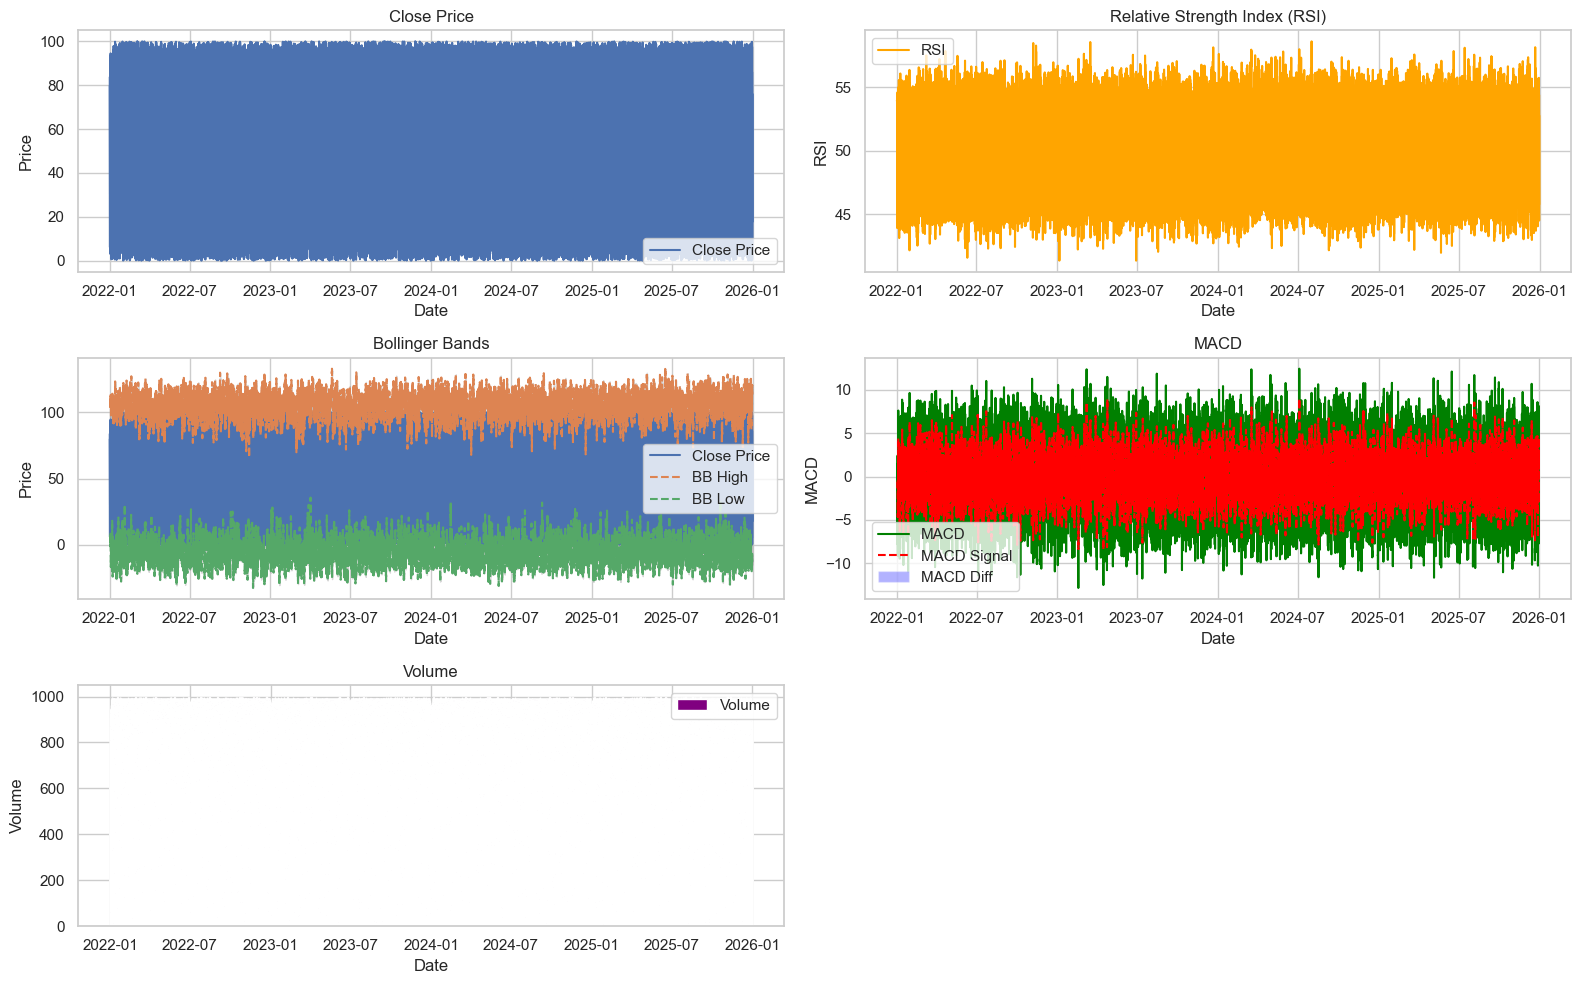

In [30]:
# Visualize the features
def visualize_features(df):
    """Visualize the features using various plots."""
    plt.figure(figsize=(16, 10))

    # Plot the closing price
    plt.subplot(3, 2, 1)
    plt.plot(df.index, df['close'], label='Close Price')
    plt.title('Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Plot the RSI
    plt.subplot(3, 2, 2)
    plt.plot(df.index, df['rsi'], label='RSI', color='orange')
    plt.title('Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()

    # Plot the Bollinger Bands
    plt.subplot(3, 2, 3)
    plt.plot(df.index, df['close'], label='Close Price')
    plt.plot(df.index, df['bb_high'], label='BB High', linestyle='--')
    plt.plot(df.index, df['bb_low'], label='BB Low', linestyle='--')
    plt.fill_between(df.index, df['bb_low'], df['bb_high'], color='gray', alpha=0.3)
    plt.title('Bollinger Bands')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Plot the MACD
    plt.subplot(3, 2, 4)
    plt.plot(df.index, df['macd'], label='MACD', color='green')
    plt.plot(df.index, df['macd_signal'], label='MACD Signal', linestyle='--', color='red')
    plt.bar(df.index, df['macd_diff'], label='MACD Diff', color='blue', alpha=0.3)
    plt.title('MACD')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.legend()

    # Plot the volume
    plt.subplot(3, 2, 5)
    plt.bar(df.index, df['volume'], label='Volume', color='purple')
    plt.title('Volume')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the features of the data_with_advanced_features dataframe
visualize_features(data_with_advanced_features)

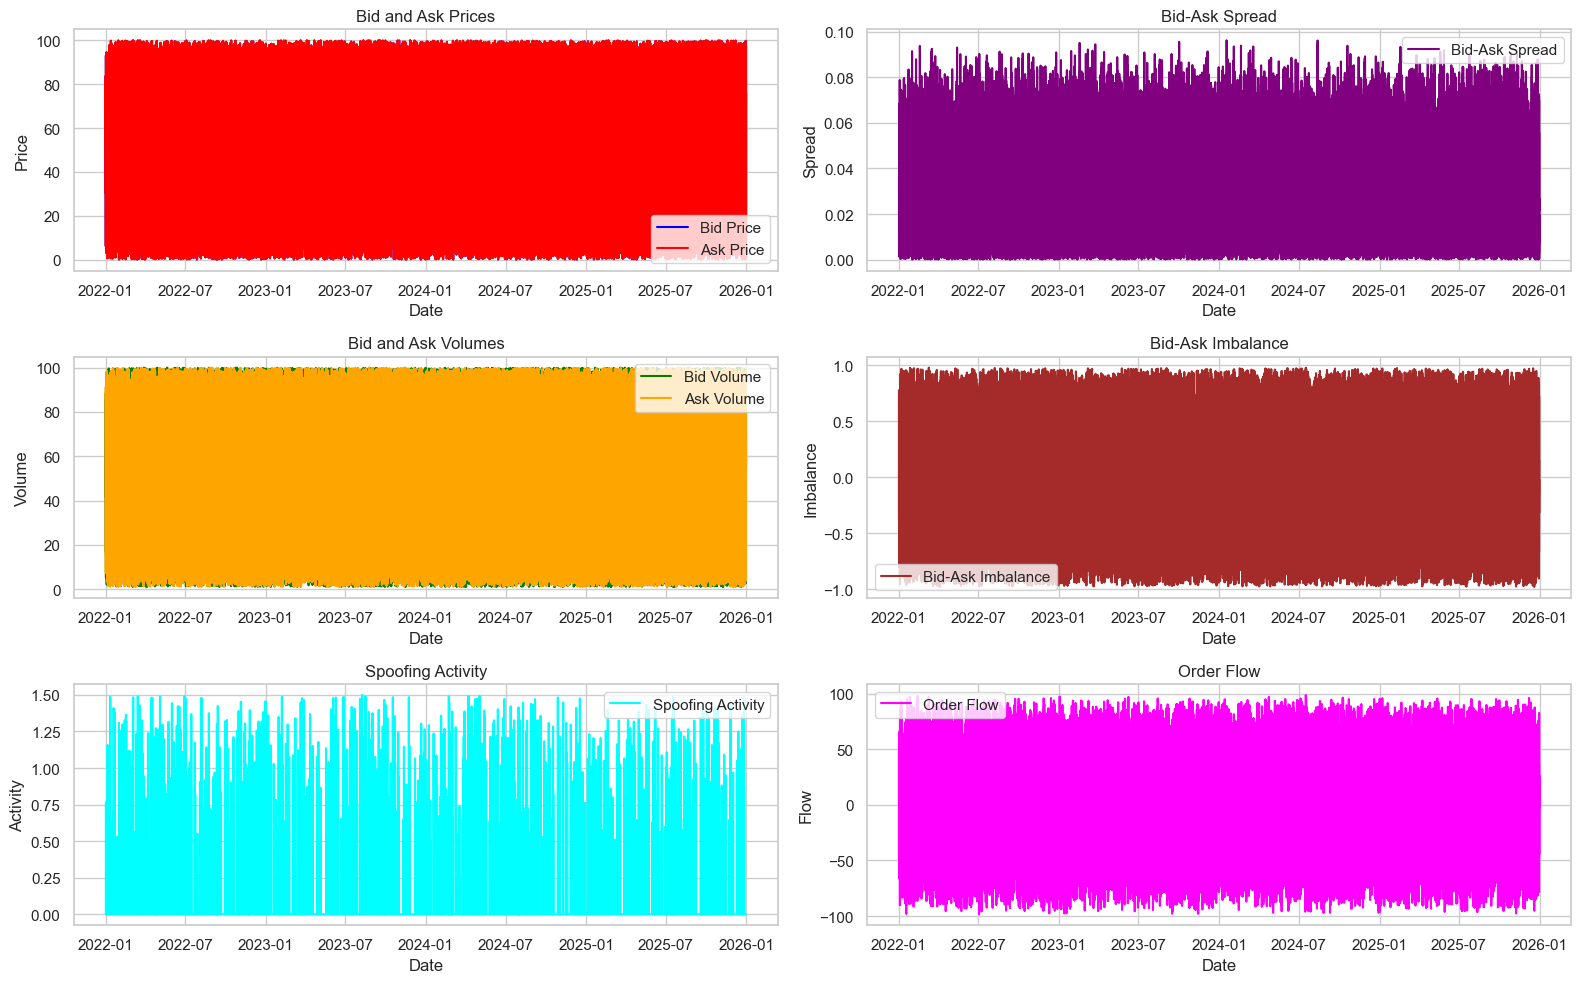

In [31]:
# Visualize the order book features
def visualize_order_book_features(df):
    """Visualize the order book features using various plots."""
    plt.figure(figsize=(16, 10))

    # Plot the bid and ask prices
    plt.subplot(3, 2, 1)
    plt.plot(df.index, df['bid_price'], label='Bid Price', color='blue')
    plt.plot(df.index, df['ask_price'], label='Ask Price', color='red')
    plt.title('Bid and Ask Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Plot the bid-ask spread
    plt.subplot(3, 2, 2)
    plt.plot(df.index, df['bid_ask_spread'], label='Bid-Ask Spread', color='purple')
    plt.title('Bid-Ask Spread')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.legend()

    # Plot the bid and ask volumes
    plt.subplot(3, 2, 3)
    plt.plot(df.index, df['bid_volume'], label='Bid Volume', color='green')
    plt.plot(df.index, df['ask_volume'], label='Ask Volume', color='orange')
    plt.title('Bid and Ask Volumes')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()

    # Plot the bid-ask imbalance
    plt.subplot(3, 2, 4)
    plt.plot(df.index, df['bid_ask_imbalance'], label='Bid-Ask Imbalance', color='brown')
    plt.title('Bid-Ask Imbalance')
    plt.xlabel('Date')
    plt.ylabel('Imbalance')
    plt.legend()

    # Plot the spoofing activity
    plt.subplot(3, 2, 5)
    plt.plot(df.index, df['spoofing_activity'], label='Spoofing Activity', color='cyan')
    plt.title('Spoofing Activity')
    plt.xlabel('Date')
    plt.ylabel('Activity')
    plt.legend()

    # Plot the order flow
    plt.subplot(3, 2, 6)
    plt.plot(df.index, df['order_flow'], label='Order Flow', color='magenta')
    plt.title('Order Flow')
    plt.xlabel('Date')
    plt.ylabel('Flow')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the order book features of the data_with_order_book dataframe
visualize_order_book_features(data_with_order_book)